1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [163]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scp
from scipy import linalg as la
%matplotlib inline

In [164]:
#* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
#  x_1 is distributed as $N(0,1)$
#  x_2 is distributed as $x_1+N(0,3)$
#  x_3 is given by $2x_1+x_2$

columns = ["x1", "x2", "x3"]
index = np.arange(1000)

df_gaus = pd.DataFrame(index=index, columns=columns) #create a new dataFrame with index and columns defined above.
df_gaus["x1"] = pd.Series(np.random.randn(1000)*1+0)
df_gaus["x2"] = pd.Series( df_gaus["x1"] + np.random.randn(1000)*1 )
df_gaus["x3"] = pd.Series( df_gaus["x2"]+2*df_gaus["x1"] )

In [165]:
# * Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
# * Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result

a_gaus = np.cov(df_gaus.T) #cov. Matrix

l_gaus, V_gaus = la.eig(a) #eigenvalues (l) and eigenvectors matrix V
U_gaus, spectrum_gaus, Vt_gaus = la.svd(a_gaus)  #SVD decomposition

print(f"Eigenvalues: {np.real_if_close(l_gaus)}\n ")
print(f"Spectrum: {spectrum_gaus}\n") #same values, different order

print(f"Eigenvectors:\n {V_gaus} \n ")
print(f"U: \n{U_gaus}\n")
print(f"Vt: \n{Vt_gaus}\n") #same vectors, different order again

Eigenvalues: [ 1.21734610e+01 -1.22059310e-17  4.50408758e-01]
 
Spectrum: [1.19994763e+01 4.82945780e-01 6.62163252e-17]

Eigenvectors:
 [[-0.26066628 -0.81649658  0.5151567 ]
 [-0.37026925 -0.40824829 -0.83440638]
 [-0.8916018   0.40824829  0.19590702]] 
 
U: 
[[-0.26805841  0.51134922 -0.81649658]
 [-0.35821392 -0.83965238 -0.40824829]
 [-0.89433074  0.18304606  0.40824829]]

Vt: 
[[-0.26805841 -0.35821392 -0.89433074]
 [ 0.51134922 -0.83965238  0.18304606]
 [ 0.81649658  0.40824829 -0.40824829]]



In [166]:
# * What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.

l_gaus = np.real_if_close(l_gaus)
Lambda=np.diag(l_gaus) #diagonal matrix from eigenvalues
print(f"Ratio between eigenvalues and trace:\n {Lambda/Lambda.trace()}\n")
print(f"Ratio between two eigenvalues and full trace : {(l_gaus[0]+l_gaus[2])/l_gaus.sum()}\n")

print("The principal components are just the first one and the third one. The ratio of the second is clearly negligible. We can say we expected this result, as long as the second component differs from the first one by a costant factor. So, keeping the first and  third component, we are able to retain more than 99%% of the total variability \n ")

df_gaus2 = (df_gaus.iloc[:,[0,2]]).copy()
df_gaus2

Ratio between eigenvalues and trace:
 [[ 9.64320865e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -9.66892977e-19  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.56791354e-02]]

Ratio between two eigenvalues and full trace : 1.0

The principal components are just the first one and the third one. The ratio of the second is clearly negligible. We can say we expected this result, as long as the second component differs from the first one by a costant factor. So, keeping the first and  third component, we are able to retain more than 99%% of the total variability 
 


,x1,x3
0,1.023185,2.649185
1,0.588423,-0.840701
2,-1.698198,-4.805990
3,0.356155,0.253726
4,-0.085830,-1.995792
...,...,...
995,0.970498,2.588297
996,0.058328,-1.128341
997,-1.934678,-5.445288
998,-1.149144,-5.175528


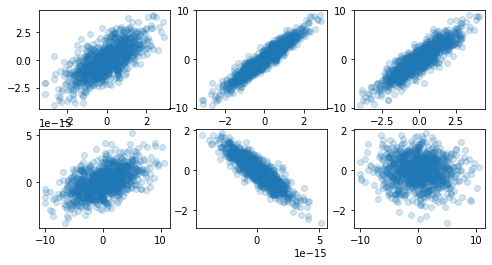

Mind the axis scales in the second raw


In [167]:
#* Redefine the data in the basis yielded by the PCA procedure
#* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) projections.


# a1 = np.cov(df_gaus2.T)
# l1, V1 = la.eig(a1)
# Lambda1=np.diag(np.real_if_close(l1))
# print (Lambda1/Lambda1.trace()) #comparison between eigenvalues weight once dropped the second component

Xp = np.dot(df_gaus, V_gaus)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))

axes[0,0].scatter(df_gaus.iloc[:,0], df_gaus.iloc[:,1], alpha = 0.2)
axes[0,1].scatter(df_gaus.iloc[:,0], df_gaus.iloc[:,2], alpha = 0.2)
axes[0,2].scatter(df_gaus.iloc[:,1], df_gaus.iloc[:,2], alpha = 0.2)
axes[1,0].scatter(Xp[:,0], Xp[:,1], alpha = 0.2)
axes[1,1].scatter(Xp[:,1], Xp[:,2], alpha = 0.2)
axes[1,2].scatter(Xp[:,0], Xp[:,2], alpha = 0.2)

plt.show()
print("Mind the axis scales in the second raw")

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [168]:
# Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

df_noise = df_gaus.copy()
for i in range(10):
    df_noise[str("Rumore" + str(i))] = pd.Series(np.random.randn(1000)*0.01+0.)
df_noise

,x1,x2,x3,Rumore0,Rumore1,Rumore2,Rumore3,Rumore4,Rumore5,Rumore6,Rumore7,Rumore8,Rumore9
0,1.023185,0.602816,2.649185,0.004706,0.004224,0.003944,-0.003778,0.003206,-0.007221,-0.010722,-0.007884,-0.005918,-0.013912
1,0.588423,-2.017547,-0.840701,0.002940,-0.003114,-0.000446,0.009276,-0.013430,-0.002113,-0.004971,-0.007021,0.001951,0.020288
2,-1.698198,-1.409594,-4.805990,0.018366,0.001492,0.022374,0.005829,-0.011423,0.003667,-0.014458,0.002491,0.006275,-0.010767
3,0.356155,-0.458585,0.253726,-0.001646,0.007174,0.000760,-0.008245,0.005159,-0.018301,-0.002750,0.003088,0.006799,-0.010499
4,-0.085830,-1.824132,-1.995792,-0.000700,-0.014074,-0.010427,0.009033,-0.000659,0.006991,0.007207,0.020180,-0.009825,-0.002019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.970498,0.647301,2.588297,0.014645,-0.000559,0.005352,0.001001,0.001556,-0.008469,-0.003991,0.009674,-0.003959,-0.010386
996,0.058328,-1.244997,-1.128341,0.014837,-0.005494,-0.005336,-0.006864,-0.008758,-0.006053,-0.002646,0.005964,0.011707,-0.016145
997,-1.934678,-1.575932,-5.445288,-0.015786,-0.021047,-0.014379,-0.006858,0.019674,-0.002657,0.010019,0.000930,-0.005151,-0.008407
998,-1.149144,-2.877240,-5.175528,0.009546,0.000905,0.017400,0.014185,0.012083,0.016370,-0.004496,0.003879,-0.011388,-0.009430


In [169]:
# Repeat the PCA procedure and compare the results with what you obtained before

a_noise = np.cov(df_noise.T)

l_noise, V_noise = la.eig(a_noise)

lam_noise=np.diag(l_noise)
print(np.real_if_close(np.diag(lam_noise/lam_noise.trace()))) 


df_rot = pd.DataFrame(np.dot(df_noise, V_noise))

l_rot, V_rot = la.eig(np.cov(df_rot.T))

print(np.real_if_close(l_rot/l_rot.sum()))
print("Again, the variables with a significative ratio are just two. The noise introduced has quite constant values.")

[ 9.61233039e-01  3.86870816e-02 -1.65603478e-17  6.44583988e-06
  9.41470890e-06  9.18291051e-06  8.69012810e-06  7.02113930e-06
  7.11505910e-06  8.35382651e-06  8.18765833e-06  7.78369606e-06
  7.68482593e-06]
[9.61233039e-01 3.86870816e-02 1.07512278e-18 6.44583988e-06
 9.41470890e-06 9.18291051e-06 8.69012810e-06 7.02113930e-06
 7.11505910e-06 8.35382651e-06 8.18765833e-06 7.78369606e-06
 7.68482593e-06]
Again, the variables with a significative ratio are just two. The noise introduced has quite constant values.


3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


In [170]:
from scipy.spatial.transform import Rotation as R

In [171]:
N = 1000
df_spring = pd.DataFrame( index = np.arange(N), columns = ["x", "y"])

df_spring["x"] = pd.Series(np.cos(np.linspace(0,6*np.pi, N)))
df_spring["y"] = pd.Series(np.random.randn(N)*0.01)
df_spring["z"] = pd.Series(np.zeros(N))

df_spring

,x,y,z
0,1.000000,-0.012192,0.0
1,0.999822,-0.009206,0.0
2,0.999288,0.003650,0.0
3,0.998398,0.004850,0.0
4,0.997153,0.001124,0.0
...,...,...,...
995,0.997153,0.008244,0.0
996,0.998398,-0.018234,0.0
997,0.999288,0.009725,0.0
998,0.999822,-0.001320,0.0


In [172]:
covM_spring = np.cov(df_spring.T)
l_spring,V_spring = la.eig(covM_spring)

df_rot = pd.DataFrame(np.dot(df_spring, np.real_if_close(V_spring.T)))

covM_rot=np.cov(df_rot.T)
l_rot, V_rot = la.eig(covM_rot)
    
lam2 = np.diag(l_rot)
print(f"Ratio between eigenvalues of the covariance matrix and their sum: \n {np.real_if_close(l_rot/l_rot.sum())} ")

print("\nThe first component, as shown, contains 99,98%% of the information.")

Ratio between eigenvalues of the covariance matrix and their sum: 
 [9.99814064e-01 1.85935884e-04 0.00000000e+00] 

The first component, as shown, contains 99,98%% of the information.


In [173]:
from scipy.spatial.transform import Rotation as R
angles = np.array( [ [90,0], [60,30], [30,60], [0,90]])

df_spring_modif = df_spring.copy()
for k in angles:
    theta = R.from_euler('x', k[0], degrees=True)
    phi   = R.from_euler('z', k[1], degrees=True)
    ang = theta*phi
    res = np.dot(ori_df,ang.as_matrix() )
    df_spring_modif[str("x"+str(k[0])+" "+str(k[1]))] = res[:,0]
    df_spring_modif[str("y"+str(k[0])+" "+str(k[1]))] = res[:,1]
    df_spring_modif[str("z"+str(k[0])+" "+str(k[1]))] = res[:,2]

df_spring_modif

,x,y,z,x90 0,y90 0,z90 0,x60 30,y60 30,z60 30,x30 60,y30 60,z30 60,x0 90,y0 90,z0 90
0,1.000000,-0.012192,0.0,1.000000,-3.337372e-18,0.015030,0.862268,-0.506508,0.013017,0.488727,-0.872534,0.007515,-0.015030,-1.000000,0.0
1,0.999822,-0.009206,0.0,0.999822,-3.187940e-18,0.014357,0.862282,-0.506128,0.012434,0.489143,-0.872088,0.007179,-0.014357,-0.999822,0.0
2,0.999288,0.003650,0.0,0.999288,-5.097247e-18,0.022956,0.859670,-0.509584,0.019880,0.482427,-0.875349,0.011478,-0.022956,-0.999288,0.0
3,0.998398,0.004850,0.0,0.998398,2.505810e-18,-0.011285,0.867460,-0.494313,-0.009773,0.507663,-0.859752,-0.005643,0.011285,-0.998398,0.0
4,0.997153,0.001124,0.0,0.997153,1.304438e-18,-0.005875,0.865029,-0.496033,-0.005088,0.502983,-0.861016,-0.002937,0.005875,-0.997153,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.997153,0.008244,0.0,0.997153,5.406250e-20,-0.000243,0.863621,-0.498471,-0.000211,0.498759,-0.863455,-0.000122,0.000243,-0.997153,0.0
996,0.998398,-0.018234,0.0,0.998398,-1.433979e-18,0.006458,0.863024,-0.501996,0.005593,0.494356,-0.867435,0.003229,-0.006458,-0.998398,0.0
997,0.999288,0.009725,0.0,0.999288,1.850918e-18,-0.008336,0.867493,-0.496035,-0.007219,0.505896,-0.861799,-0.004168,0.008336,-0.999288,0.0
998,0.999822,-0.001320,0.0,0.999822,-3.014567e-18,0.013576,0.862477,-0.505790,0.011758,0.489729,-0.871750,0.006788,-0.013576,-0.999822,0.0


Ratio between eigenvalues and their sum: 
 [ 9.99799416e-01  1.63465783e-04  3.71177525e-05  1.46600520e-16
  9.27328082e-17  4.11383668e-17 -3.16088377e-17 -8.65275114e-18
 -2.92821518e-20  8.06529688e-21 -4.39117689e-21 -2.15571912e-21
 -2.69726942e-33  0.00000000e+00  0.00000000e+00]
[9.99814064e-01 1.85935884e-04 0.00000000e+00]


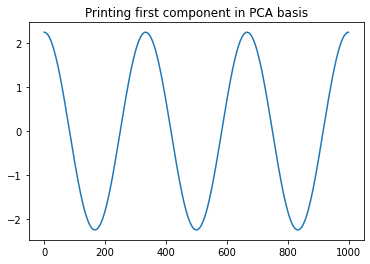

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.236069,-0.030315,0.011324,6.938894e-16,1.101896e-14,5.440093e-15,1.623701e-15,8.187895e-16,-6.938894e-18,-1.734723e-17,0.000000e+00,2.220446e-16,1.514613e-27,0.0,0.0
1,2.235671,-0.028899,0.008370,-8.666140e-16,9.234338e-15,3.810891e-15,1.617367e-15,8.370094e-16,2.682459e-18,-1.842262e-17,2.742636e-17,2.920737e-16,-3.915707e-27,0.0,0.0
2,2.234476,-0.045792,-0.004883,-1.449111e-14,5.318412e-15,-4.537069e-15,3.284565e-15,1.159277e-15,1.065130e-17,-1.717847e-17,4.603838e-17,2.710245e-16,-4.762919e-26,0.0,0.0
3,2.232486,0.022700,-0.004483,4.600498e-15,-5.902868e-15,-1.834931e-15,-5.890404e-16,-6.605698e-17,-6.377609e-18,-2.494109e-17,2.968609e-17,1.787511e-16,1.074095e-26,0.0,0.0
4,2.229702,0.011795,-0.001012,3.736841e-15,-2.245498e-15,-2.596263e-16,-1.062932e-16,1.741036e-16,-6.981654e-18,-1.956191e-17,7.255958e-18,3.053447e-16,9.365006e-27,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.229702,0.000701,-0.008392,-4.049905e-15,-4.218210e-15,-4.863550e-15,9.210730e-16,3.445990e-16,-2.905309e-19,-2.131336e-17,5.135367e-17,1.598481e-16,-1.635895e-26,0.0,0.0
996,2.232488,-0.013316,0.017766,9.672176e-15,1.149624e-14,9.824162e-15,2.715874e-16,4.147077e-16,-3.032048e-18,-2.234737e-17,6.561274e-17,4.390697e-16,3.003925e-26,0.0,0.0
997,2.234475,0.016916,-0.009495,-5.654073e-16,-7.459726e-15,-4.979407e-15,2.348992e-17,7.879071e-17,1.190689e-19,-2.152364e-17,-1.301701e-18,1.982762e-16,-5.106816e-27,0.0,0.0
998,2.235670,-0.027154,0.000523,-5.703677e-15,4.977161e-15,-6.837610e-16,1.922883e-15,8.320514e-16,-7.849767e-18,-1.929835e-17,-1.991372e-17,2.193254e-16,-2.000886e-26,0.0,0.0


In [174]:
#PCA on rotated spring

covM_springrot = np.cov(df_spring_modif.T)

l_sprot, V_sprot = la.eig(covM_springrot)
l_sprot = np.real_if_close(l_sprot)

print(f"Ratio between eigenvalues and their sum: \n {l_sprot/l_sprot.sum()}")

#rotation in PCA basis
df_spring_nb = pd.DataFrame(np.real_if_close(np.dot(df_spring_modif, V_sprot)))

l_PCA, V_PCA = la.eig(np.cov(df_rot.T))

print(np.real_if_close(l_PCA/l_PCA.sum()))
plt.plot(df_spring_nb.iloc[:,0])
plt.title("Printing first component in PCA basis")
plt.show()
df_spring_nb

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [175]:
# get the dataset and its description on the proper data directory
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

In [176]:
#again
filename = "/home/lorenzo/data/magic04.data"
descname = "/home/lorenzo/data/magic04.names"

index =  [  "fLength",      #continuous  # major axis of ellipse [mm]
            "fWidth",       #continuous  # minor axis of ellipse [mm] 
            "fSize",        #continuous  # 10-log of sum of content of all pixels [in #phot]
            "fConc",        #continuous  # ratio of sum of two highest pixels over fSize  [ratio]
            "fConc1",       #continuous  # ratio of highest pixel over fSize  [ratio]
            "fAsym",        #continuous  # distance from highest pixel to center, projected onto major axis [mm]
            "fM3Long",      #continuous  # 3rd root of third moment along major axis  [mm] 
            "fM3Trans",     #continuous  # 3rd root of third moment along minor axis  [mm]
            "fAlpha",       #continuous  # angle of major axis with vector to origin [deg]
            "fDist",        #continuous  # distance from origin to center of ellipse [mm]
            "classification"# g,h        # gamma (signal), hadron (background)
         ]  
# binary classification.. first idea Machine learing algorithm for classification. 

magic_df = pd.read_csv(filename, names = index)

dic = {'g': 1, 'h': 0}
magic_df['classification'] = magic_df['classification'].map(dic, na_action='ignore')

gamma_df = magic_df#[magic_df['classification']==1]  for focusing only on gammas

gamma_cov = np.cov(gamma_df.T)
l_cov, V_cov = la.eig(gamma_cov)

gammarot_df = pd.DataFrame(np.dot(gamma_df, np.real_if_close(V_cov.T)))

gammarot_cov=np.cov(gammarot_df.T)
l_rot, V_rot = la.eig(gammarot_cov)

res = np.diag(l_rot)
print(np.real_if_close(np.diag(res/res.trace())))

print("\nOnce more, most of the information is related to a first three/four features. In this way we are clearly able to reduce the size of our dataset. It would be also nice to see how a binary classification problem would perform whether we use the entire dataset or just the most relevant features.")

[4.40466498e-01 2.57987592e-01 1.34981328e-01 8.88172454e-02
 4.08498986e-02 2.90261107e-02 7.85438231e-03 1.04326075e-05
 5.77816391e-06 2.57395320e-08 7.09203170e-07]

Once more, most of the information is related to a first three/four features. In this way we are clearly able to reduce the size of our dataset. It would be also nice to see how a binary classification problem would perform whether we use the entire dataset or just the most relevant features.
